In [2]:
import pandas as pd
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras import layers
import time
from IPython import display
import math
import time

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def get_y(x):
    return x*x

def sample_data(n, num_points):
    x = (np.random.random_sample((num_points,))-0.5)*10
    x = np.sort(x).tolist()
    a = np.random.uniform(-10, 10)
    b = np.random.uniform(-1, 1)
    c = np.random.uniform(-10, 10)
    y = []
    for i in range(0,num_points):
        y.append(x[i]**2 + c)
    combined = x+y
    data = np.array([combined])
    for i in range(n-1):
        c = np.random.uniform(-10, 10)
        x = (np.random.random_sample((num_points,))-0.5)*10
        x = np.sort(x).tolist()
        y = []
        for i in range(0,num_points):
#             yi = a*x[i]**2 + b*x[i] + c 
#             yi = x[i]**2
            y.append(x[i]**2 + c)
#             data.append([x[i], yi])
        combined = x + y
        data = np.vstack((data, combined))
    return data


def pi_sample_data(n, f):
    data = []
    for i in range(n):
        x = np.random.uniform(0, 1)
        data.append([x, math.sin(x*np.pi*f) + np.random.uniform(0,1)])
    return np.array(data)
    

def sample_z(m, n):
    seed = np.random.uniform(-1., 1., size=[m, n])
    seed = np.sort(seed)
    return seed

(1, 100)
-4.362606945021497
[ 7.60460691 -0.28116882  5.72064115  4.65864458  6.22690609]


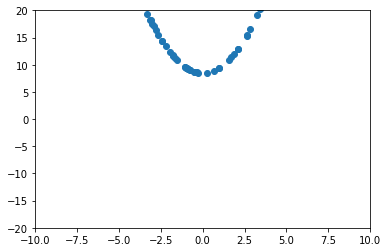

In [50]:
x = []
y = []
data = sample_data(n=1, num_points = 50)
print(data.shape)
print(data[0,1])
for i in range(0, int(data.shape[1]/2)):
    x.append(data[0,i])
    
for i in range(int(data.shape[1]/2), int(data.shape[1])):
        y.append(data[0,i])
        
plt.ylim(-20.0, 20.0)
plt.xlim(-10, 10)
plt.scatter(x,y)
print((np.random.random_sample((5,))*10-0.5))

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
0.051164265473683676
Iterations: 0	 Discriminator loss: 0.8471	 Generator loss: 0.6583


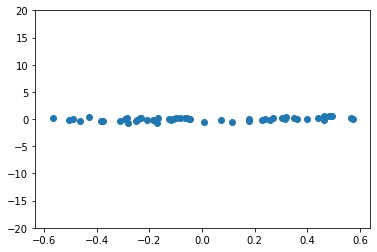

4.282998716831207
Iterations: 4000	 Discriminator loss: 0.2517	 Generator loss: 1.9707


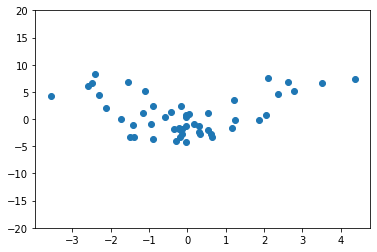

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
tf.reset_default_graph()
start = time.time()
num_points = 50
gen_input_size = 200
def generator(z, hsize=[1000,200], reuse=False):
    with tf.variable_scope("GAN/Generator", reuse=reuse) as scope:
        h1 = tf.layers.dense(z, hsize[0], activation=tf.nn.leaky_relu)
#         h2 = tf.layers.dense(h1, hsize[1], activation=tf.nn.leaky_relu)
#         h3 = tf.layers.dense(h2, hsize[2], activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h1, num_points*2)
    return out

def discriminator(x, hsize=[1000,20000], reuse=False):
    with tf.variable_scope("GAN/Discriminator", reuse=reuse):
        h1 = tf.layers.dense(x, hsize[0], activation = tf.nn.leaky_relu)
#         h2 = tf.layers.dense(h1, hsize[1], activation = tf.nn.leaky_relu)
        h3 = tf.layers.dense(h1, 2)
        out = tf.layers.dense(h1, 1)
    return out, h3

x = tf.placeholder(tf.float32, [None, num_points*2])
z = tf.placeholder(tf.float32, [None, gen_input_size])

G_sample = generator(z)
r_logits, r_rep = discriminator(x)
f_logits, g_rep = discriminator(G_sample, reuse=True)
disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits, labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits, labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits, labels=tf.ones_like(f_logits)))

# disc_loss = tf.reduce_mean(tf.squared_difference(r_logits, tf.ones_like(r_logits)) + tf.squared_difference(f_logits, tf.zeros_like(f_logits)))
# gen_loss = tf.reduce_mean(tf.squared_difference(f_logits, tf.ones_like(f_logits)))

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="GAN/Discriminator")
gen_step = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(gen_loss, var_list = gen_vars)
disc_step = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(disc_loss, var_list = disc_vars)

sess = tf.Session()
tf.global_variables_initializer().run(session=sess)
GAN_saver = tf.train.Saver()

batch_size = 256
nd_steps = 1
ng_steps = 1
# x_data = sample_data(batch_size)
# x_data = pi_sample_data(batch_size, 2)
for i in range(4001):
    x_batch = sample_data(n=batch_size, num_points=num_points)
#     x_batch = pi_sample_data(batch_size, 2)
#     x_batch = x_data
    z_batch = sample_z(batch_size, gen_input_size)
    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={x: x_batch, z: z_batch})
    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict = {z: z_batch})
    if i%4000 == 0:
        print((time.time()-start)/60)
        print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
        g_plot = sess.run(G_sample, feed_dict={z: sample_z(1, gen_input_size)})
        x_ = []
        y_ = []
        for i in range(0, int(g_plot.shape[1]/2)):
            x_.append(g_plot[0,i])

        for i in range(int(g_plot.shape[1]/2), int(g_plot.shape[1])):
            y_.append(g_plot[0,i])

        plt.ylim(-20.0, 20)
        plt.scatter(x_, y_)
        plt.show()
        start = time.time()
saver_path = GAN_saver.save(sess, "GAN_Vars")

In [5]:
with tf.Session() as sess:
    vars = tf.trainable_variables()
    print(vars)

[<tf.Variable 'GAN/Generator/dense/kernel:0' shape=(10, 30) dtype=float32_ref>, <tf.Variable 'GAN/Generator/dense/bias:0' shape=(30,) dtype=float32_ref>, <tf.Variable 'GAN/Generator/dense_1/kernel:0' shape=(30, 15) dtype=float32_ref>, <tf.Variable 'GAN/Generator/dense_1/bias:0' shape=(15,) dtype=float32_ref>, <tf.Variable 'GAN/Generator/dense_2/kernel:0' shape=(15, 100) dtype=float32_ref>, <tf.Variable 'GAN/Generator/dense_2/bias:0' shape=(100,) dtype=float32_ref>, <tf.Variable 'GAN/Discriminator/dense/kernel:0' shape=(100, 15) dtype=float32_ref>, <tf.Variable 'GAN/Discriminator/dense/bias:0' shape=(15,) dtype=float32_ref>, <tf.Variable 'GAN/Discriminator/dense_1/kernel:0' shape=(15, 15) dtype=float32_ref>, <tf.Variable 'GAN/Discriminator/dense_1/bias:0' shape=(15,) dtype=float32_ref>, <tf.Variable 'GAN/Discriminator/dense_2/kernel:0' shape=(15, 2) dtype=float32_ref>, <tf.Variable 'GAN/Discriminator/dense_2/bias:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'GAN/Discriminator/dense_3/

<class 'tensorflow.python.framework.ops.Tensor'>
INFO:tensorflow:Restoring parameters from GAN_Vars
(1, 200)
<class 'numpy.ndarray'>
(1, 100)


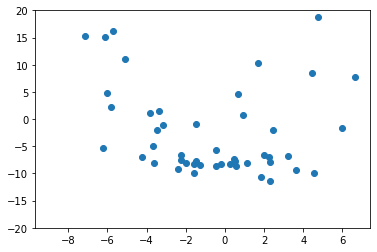

In [183]:
z = tf.placeholder(tf.float32, [None, gen_input_size])
test = generator(z, reuse=True)

print(type(G_sample))
with tf.Session() as sess:
    GAN_saver.restore(sess, "GAN_Vars")
#     tf.global_variables_initializer().run(session=sess)
    sample = sample_z(1, gen_input_size)
    print(sample.shape)
    print(type(sample))
    g_plot = sess.run(test, feed_dict={z: sample})
    x_ = []
    y_ = []
    print(g_plot.shape)
    for i in range(0, int(g_plot.shape[1]/2)):
        x_.append(g_plot[0,i])

    for i in range(int(g_plot.shape[1]/2), int(g_plot.shape[1])):
        y_.append(g_plot[0,i])
        
    
    plt.ylim(-20.0, 20)
#     plt.ylim(-20.0, 20)
    plt.scatter(x_, y_)
    plt.show()